In [1]:
# This code is provided for Deep Learning (CS 482/682) Homework 6 practice.
# The network structure is a simplified U-net. You need to finish the last layers
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
# Modified by Hongtao Wu on Oct 11, 2019 for Fall 2019 Machine Learning: Deep Learning HW6

#Jason Zhang Jzhan127

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.datasets as datasets

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.FashionMNIST(root='./', 
                            train=True, 
                            download=True,
                            transform=transform)

test_data = datasets.FashionMNIST(root='./', 
                           train=False, 
                           download=True,
                           transform=transform)

# Plot training loss, Model Accuracy
def plot(training_loss, model_accs):
    plt.figure(300)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')   
    plt.plot(training_loss, 'b', label='Training')
    plt.figure(400)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Percent Accuracy')   
    plt.plot(model_accs, 'b', label= 'Validation')

# 2 a

In [2]:
train_batch_size = 300
test_batch_size = 1000
lr = 0.0001
num_epochs = 10

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=test_batch_size, 
                                           shuffle=True)
# Making the model

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512]
vgg_feats = make_layers(cfg)
model = models.vgg16(num_classes = 10)
model.features = vgg_feats
loss = nn.CrossEntropyLoss()
loss.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr)
model.cuda()
training_loss = []
model_accs = []

for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    training_loss_tot = 0
    count = 0
    
    print("Training...")
    for ind, training_data in enumerate(train_loader):
        inp = training_data[0].numpy()
        stack_data = np.stack((inp, inp, inp), axis = 1)
        stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
        data = torch.from_numpy(stack_data)
        x = autograd.Variable(data).cuda()
        y = autograd.Variable(training_data[1]).cuda()

        optimizer.zero_grad()
        y_hat = model(x)
        train_loss = loss(y_hat, y)
        train_loss.backward()
        optimizer.step()
        training_loss_tot += train_loss.data
        count += 1
#         print(train_loss.data.item())
    print("Training Loss: ", training_loss_tot / count)
    train_loss_avg = train_loss.data.item() / count
    training_loss.append(train_loss_avg)
    
    print("Validation...")
    model.eval()
    acc_tot = 0
    count = 0
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            inp = valid_data[0].numpy()
            stack_data = np.stack((inp, inp, inp), axis = 1)
            stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
            data = torch.from_numpy(stack_data)
            x = autograd.Variable(data).cuda()
            y = autograd.Variable(valid_data[1]).cuda()
            y_hat = model(x)
            num_samples = y.shape[0]
            pred = torch.max(y_hat, axis = 1)[1]
            acc = float(((pred == y).sum()))/num_samples
            acc_tot += acc
            count += 1
    curr_acc = acc_tot / count * 100
    print("Accuracy: {0:.2f}%".format(curr_acc))
    model_accs.append(curr_acc)
    


EPOCH 1 of 10

Training...
Training Loss:  tensor(1.7465, device='cuda:0')
Validation...
Accuracy: 63.89%

EPOCH 2 of 10

Training...
Training Loss:  tensor(0.7652, device='cuda:0')
Validation...
Accuracy: 76.43%

EPOCH 3 of 10

Training...
Training Loss:  tensor(0.5939, device='cuda:0')
Validation...
Accuracy: 79.41%

EPOCH 4 of 10

Training...
Training Loss:  tensor(0.5134, device='cuda:0')
Validation...
Accuracy: 81.90%

EPOCH 5 of 10

Training...
Training Loss:  tensor(0.4479, device='cuda:0')
Validation...
Accuracy: 83.85%

EPOCH 6 of 10

Training...
Training Loss:  tensor(0.4107, device='cuda:0')
Validation...
Accuracy: 83.54%

EPOCH 7 of 10

Training...
Training Loss:  tensor(0.3742, device='cuda:0')
Validation...
Accuracy: 86.56%

EPOCH 8 of 10

Training...
Training Loss:  tensor(0.3499, device='cuda:0')
Validation...
Accuracy: 88.07%

EPOCH 9 of 10

Training...
Training Loss:  tensor(0.3160, device='cuda:0')
Validation...
Accuracy: 88.55%

EPOCH 10 of 10

Training...
Training

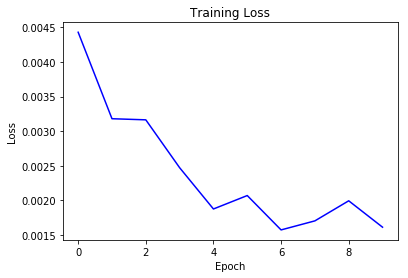

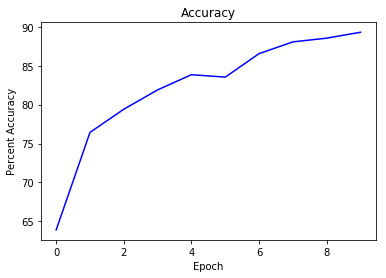

In [3]:
plot(training_loss, model_accs)

# 2 b

In [2]:
# Making the model

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512]
vgg_feats = make_layers(cfg)
modelPre = models.vgg16(pretrained=True)

for s in modelPre.parameters():
    s.requires_grad = False

modelPre.features = vgg_feats
modelPre.classifier[6] = nn.Linear(4096, 10)


modelPre.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
train_batch_size = 300
test_batch_size = 1000
lr = 0.0001
num_epochs = 10

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=test_batch_size, 
                                           shuffle=True)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelPre.parameters(), lr)
training_loss = []
model_accs = []
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    modelPre.train()
    training_loss_tot = 0
    count = 0
    
    print("Training...")
    for ind, training_data in enumerate(train_loader):
        inp = training_data[0].numpy()
        stack_data = np.stack((inp, inp, inp), axis = 1)
        stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
        data = torch.from_numpy(stack_data)
        x = autograd.Variable(data).cuda()
        y = autograd.Variable(training_data[1]).cuda()

        optimizer.zero_grad()
        y_hat = modelPre(x)
        train_loss = loss(y_hat, y)
        train_loss.backward()
        optimizer.step()
        training_loss_tot += train_loss.data
        count += 1
    print("Training Loss: ", training_loss_tot / count)
    train_loss_avg = train_loss.data.item() / count
    training_loss.append(train_loss_avg)
    
    print("Validation...")
    modelPre.eval()
    acc_tot = 0
    count = 0
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            inp = valid_data[0].numpy()
            stack_data = np.stack((inp, inp, inp), axis = 1)
            stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
            data = torch.from_numpy(stack_data)
            x = autograd.Variable(data).cuda()
            y = autograd.Variable(valid_data[1]).cuda()
            y_hat = modelPre(x)
            num_samples = y.shape[0]
            pred = torch.max(y_hat, axis = 1)[1]
            acc = float(((pred == y).sum()))/num_samples
            acc_tot += acc
            count += 1
    curr_acc = acc_tot / count * 100
    print("Accuracy: {0:.2f}%".format(curr_acc))
    model_accs.append(curr_acc)


EPOCH 1 of 10

Training...
Training Loss:  tensor(1.8238, device='cuda:0')
Validation...
Accuracy: 45.64%

EPOCH 2 of 10

Training...
Training Loss:  tensor(1.0076, device='cuda:0')
Validation...
Accuracy: 68.98%

EPOCH 3 of 10

Training...
Training Loss:  tensor(0.7348, device='cuda:0')
Validation...
Accuracy: 74.72%

EPOCH 4 of 10

Training...
Training Loss:  tensor(0.6087, device='cuda:0')
Validation...
Accuracy: 78.52%

EPOCH 5 of 10

Training...
Training Loss:  tensor(0.5359, device='cuda:0')
Validation...
Accuracy: 80.37%

EPOCH 6 of 10

Training...
Training Loss:  tensor(0.4802, device='cuda:0')
Validation...
Accuracy: 80.34%

EPOCH 7 of 10

Training...
Training Loss:  tensor(0.4245, device='cuda:0')
Validation...
Accuracy: 85.85%

EPOCH 8 of 10

Training...
Training Loss:  tensor(0.3886, device='cuda:0')
Validation...
Accuracy: 85.86%

EPOCH 9 of 10

Training...
Training Loss:  tensor(0.3526, device='cuda:0')
Validation...
Accuracy: 87.23%

EPOCH 10 of 10

Training...
Training

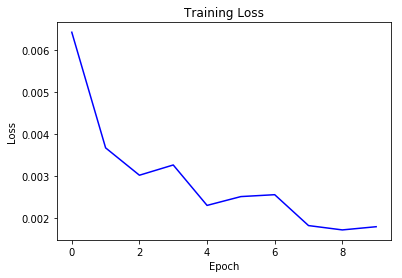

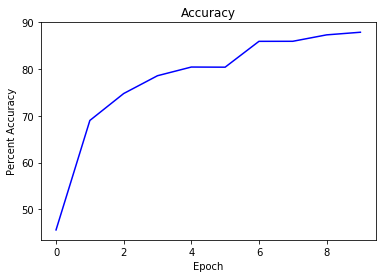

In [4]:
plot(training_loss, model_accs)

# 2 C

In [2]:
# Making the model

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512]
vgg_feats = make_layers(cfg)
modelPre = models.vgg16(pretrained=True)

#Unfreeze all fully connected
child_counter = 0
for child in modelPre.children():
    layer_count = 0
    if child_counter == 2:
        layer_count = 0
        for s in child.parameters():
            if layer_count != 5 and layer_count != 0 and layer_count != 2:
                s.requires_grad = False
            layer_count += 1
    else:
        for s in child.parameters():   
            s.requires_grad = False
    child_counter += 1

modelPre.features = vgg_feats
modelPre.classifier[6] = nn.Linear(4096, 10)

modelPre.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
train_batch_size = 300
test_batch_size = 1000
lr = 0.0001
num_epochs = 10

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=test_batch_size, 
                                           shuffle=True)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelPre.parameters(), lr)
training_loss = []
model_accs = []
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    modelPre.train()
    training_loss_tot = 0
    count = 0
    
    print("Training...")
    for ind, training_data in enumerate(train_loader):
        inp = training_data[0].numpy()
        stack_data = np.stack((inp, inp, inp), axis = 1)
        stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
        data = torch.from_numpy(stack_data)
        x = autograd.Variable(data).cuda()
        y = autograd.Variable(training_data[1]).cuda()

        optimizer.zero_grad()
        y_hat = modelPre(x)
        train_loss = loss(y_hat, y)
        train_loss.backward()
        optimizer.step()
        training_loss_tot += train_loss.data
        count += 1
    print("Training Loss: ", training_loss_tot / count)
    train_loss_avg = train_loss.data.item() / count
    training_loss.append(train_loss_avg)
    
    print("Validation...")
    modelPre.eval()
    acc_tot = 0
    count = 0
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            inp = valid_data[0].numpy()
            stack_data = np.stack((inp, inp, inp), axis = 1)
            stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
            data = torch.from_numpy(stack_data)
            x = autograd.Variable(data).cuda()
            y = autograd.Variable(valid_data[1]).cuda()
            y_hat = modelPre(x)
            num_samples = y.shape[0]
            pred = torch.max(y_hat, axis = 1)[1]
            acc = float(((pred == y).sum()))/num_samples
            acc_tot += acc
            count += 1
    curr_acc = acc_tot / count * 100
    print("Accuracy: {0:.2f}%".format(curr_acc))
    model_accs.append(curr_acc)


EPOCH 1 of 10

Training...
Training Loss:  tensor(1.7818, device='cuda:0')
Validation...
Accuracy: 51.33%

EPOCH 2 of 10

Training...
Training Loss:  tensor(0.9637, device='cuda:0')
Validation...
Accuracy: 69.32%

EPOCH 3 of 10

Training...
Training Loss:  tensor(0.6758, device='cuda:0')
Validation...
Accuracy: 77.53%

EPOCH 4 of 10

Training...
Training Loss:  tensor(0.5488, device='cuda:0')
Validation...
Accuracy: 80.36%

EPOCH 5 of 10

Training...
Training Loss:  tensor(0.4903, device='cuda:0')
Validation...
Accuracy: 81.10%

EPOCH 6 of 10

Training...
Training Loss:  tensor(0.4434, device='cuda:0')
Validation...
Accuracy: 84.12%

EPOCH 7 of 10

Training...
Training Loss:  tensor(0.4163, device='cuda:0')
Validation...
Accuracy: 83.75%

EPOCH 8 of 10

Training...
Training Loss:  tensor(0.3834, device='cuda:0')
Validation...
Accuracy: 86.66%

EPOCH 9 of 10

Training...
Training Loss:  tensor(0.3443, device='cuda:0')
Validation...
Accuracy: 86.89%

EPOCH 10 of 10

Training...
Training

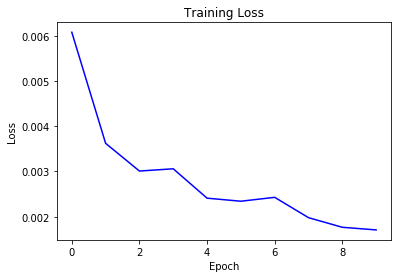

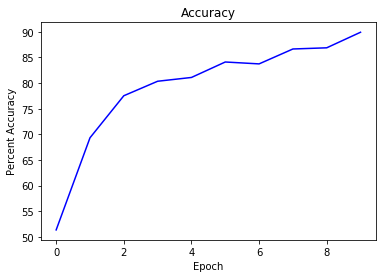

In [4]:
plot(training_loss, model_accs)